In [172]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)


In [173]:
sessionA = 'classinsight-cmu_05748A_ghc_4101_201902051630'
sessionB = 'classinsight-cmu_05748A_ghc_4101_201902141630'
course = '05748A'


In [174]:
sessionA_frame_dir = f'{base_dir}/{course}/{sessionA}-front'
sessionB_frame_dir = f'{base_dir}/{course}/{sessionB}-front'


## Get embedding and gaze information for all frames for all sessions (Run if needed, commented out for now)?


## Get frame file data for all sessions


In [175]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    # if os.path.exists(course_cache_file):
    #     frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
    #     continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
        
frame_file_data.keys()


Got metadata for course: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
Got metadata for course: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front


dict_keys(['05748A'])

In [176]:
# writing a generic loop to get embedding info from all courses in frame file data
emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info'
os.makedirs(emb_analysis_session_data,exist_ok=True)

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_emb_cache_file = f"{emb_analysis_session_data}/{session_id}.pb"
        try:
            if not os.path.exists(session_emb_cache_file):
                session_dir = frame_file_data[course][session_id]['dir_location']
                frame_ids = frame_file_data[course][session_id]['frame_ids']
                session_emb_info = {}
                for frame_id in frame_ids:
                    frame_number, frame_data = pickle.load(open(f'{session_dir}/{frame_id}.pb','rb'))
                    frame_emb_info = {int(person_info['track_id']):{
                        'bbox': person_info['bbox'] if 'bbox' in person_info else None,
                        'rvec': person_info['rvec'] if 'rvec' in person_info else None,
                        'gaze_2d':person_info['gaze_2d'] if 'gaze_2d' in person_info else None,
                        'face_embedding': person_info['face_embedding'] if 'face_embedding' in person_info else None,
                    } for person_info in frame_data}
                    session_emb_info[frame_id] = frame_emb_info
                pickle.dump(session_emb_info, open(session_emb_cache_file,'wb'))
                print(f"Got emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            else:
                ...
                print(f"FILE EXISTS: emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
        except:
            print(f"ERROR: Unable to get session emb for: {course_idx}-{course}, session:{session_idx}-{session_id}")
            unfinished_sessions.append((course, session_id))
            print(traceback.format_exc())
    

Got emb info for session: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
Got emb info for session: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front


In [177]:
sessionA_emb_info = pickle.load(open(f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info/{sessionA}-front.pb','rb'))
sessionB_emb_info = pickle.load(open(f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info/{sessionB}-front.pb','rb'))


In [178]:
sessionA_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionA}-front.pb","rb"))
sessionB_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionB}-front.pb","rb"))


In [179]:
sessionB_id_map[1295]


10000

In [180]:
sessionA_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sessionA}/{sessionA}-front.avi'
sessionB_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sessionB}/{sessionB}-front.avi'


## Replace raw ids with mapped ids for both sessions


In [181]:
sessionA_emb_info = {
    xr:{
        sessionA_id_map[yr]:sessionA_emb_info[xr][yr] 
            for yr in sessionA_emb_info[xr] if not (sessionA_id_map[yr]==10000)} for xr in sessionA_emb_info}


In [182]:
sessionB_emb_info = {
    xr:{
        sessionB_id_map[yr]:sessionB_emb_info[xr][yr] 
            for yr in sessionB_emb_info[xr] if not (sessionB_id_map[yr]==10000)} for xr in sessionB_emb_info}


In [183]:
len(sessionA_emb_info.keys()), len(sessionB_emb_info.keys())


(11922, 23913)

In [184]:
# sessionA_emb_info[0][1]['face_embedding'].tolist()


In [185]:
# arrange info as per tracking id across both sessions
# pitch, roll, yaw= sessionA_emb_info[0][9]['rvec'][0]
gaze_infoA = {}
emb_infoA = {}
for frame_number in sessionA_emb_info:
    for trackId in sessionA_emb_info[frame_number]:
        if trackId not in gaze_infoA:
            gaze_infoA[trackId] = []
            emb_infoA[trackId]=[]
        # get  gaze info
        try:
            pitch, roll, yaw= sessionA_emb_info[frame_number][trackId]['rvec'][0]
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionA_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            gaze_infoA[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = sessionA_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_infoA[trackId].append([frame_number]+face_emb)
        except:
            continue

for id in gaze_infoA:
    gaze_infoA[id] = pd.DataFrame(gaze_infoA[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoA[id] =pd.DataFrame(emb_infoA[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')

gaze_infoB = {}
emb_infoB = {}
for frame_number in sessionB_emb_info:
    for trackId in sessionB_emb_info[frame_number]:
        if trackId not in gaze_infoB:
            gaze_infoB[trackId] = []
            emb_infoB[trackId]=[]
        # get  gaze info
        try:
            pitch, roll, yaw= sessionB_emb_info[frame_number][trackId]['rvec'][0]    
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionB_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_infoB[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = sessionB_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_infoB[trackId].append([frame_number]+face_emb)
        except:
            continue


for id in gaze_infoB:
    gaze_infoB[id] = pd.DataFrame(gaze_infoB[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoB[id] =pd.DataFrame(emb_infoB[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')

len(gaze_infoA.keys()), len(gaze_infoB.keys())


(35, 37)

In [186]:
sprint({xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0]) for xr in emb_infoA})


Dict: {xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0]) for xr in emb_infoA}
Key: Value


{0: (11903, 11903),
 1: (11701, 11701),
 2: (11836, 11836),
 3: (11797, 11797),
 4: (576, 576),
 5: (11826, 11826),
 6: (11917, 11917),
 7: (11825, 11825),
 8: (11898, 11898),
 9: (11221, 11221),
 10: (4366, 4366),
 11: (5946, 5946),
 12: (11529, 11529),
 13: (11590, 11590),
 14: (11309, 11309),
 15: (11342, 11342),
 16: (10007, 10007),
 17: (49, 49),
 18: (24, 24),
 19: (9629, 9629),
 20: (134, 134),
 21: (7191, 7191),
 22: (6, 6),
 23: (33, 33),
 24: (1144, 1144),
 25: (56, 56),
 26: (3454, 3454),
 27: (84, 84),
 28: (26, 26),
 29: (81, 81),
 30: (4862, 4862),
 31: (252, 252),
 32: (1799, 1799),
 33: (11, 11),
 34: (90, 90)}

In [187]:
sprint({xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0]) for xr in emb_infoB})


Dict: {xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0]) for xr in emb_infoB}
Key: Value


{0: (23858, 23858),
 1: (23871, 23871),
 2: (20407, 20407),
 3: (17549, 17549),
 4: (23891, 23891),
 5: (23809, 23809),
 6: (23497, 23497),
 7: (17329, 17329),
 8: (23265, 23265),
 9: (23314, 23314),
 10: (18783, 18783),
 11: (777, 777),
 12: (20240, 20240),
 13: (65, 65),
 14: (22246, 22246),
 15: (92, 92),
 16: (14917, 14917),
 17: (19626, 19626),
 18: (19901, 19901),
 19: (100, 100),
 20: (6323, 6323),
 21: (157, 157),
 22: (455, 455),
 23: (272, 272),
 24: (1484, 1484),
 25: (1573, 1573),
 26: (5766, 5766),
 27: (358, 358),
 28: (29, 29),
 29: (1129, 1129),
 30: (97, 97),
 31: (169, 169),
 32: (1328, 1328),
 33: (2345, 2345),
 34: (147, 147),
 35: (2469, 2469),
 36: (2129, 2129)}

In [10]:
sprint({xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0]) for xr in emb_infoA})


Dict: {xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0]) for xr in emb_infoA}
Key: Value


{0: (11903, 11903),
 1: (11701, 11701),
 2: (11836, 0),
 3: (11797, 0),
 4: (576, 0),
 5: (11826, 11826),
 6: (11917, 0),
 7: (11825, 11825),
 8: (11898, 11898),
 9: (11221, 11221),
 10: (4366, 0),
 11: (5946, 5946),
 12: (11529, 0),
 13: (11590, 11590),
 14: (11309, 0),
 15: (11342, 2332),
 16: (10007, 0),
 17: (49, 4),
 18: (24, 0),
 19: (9630, 0),
 20: (134, 130),
 21: (7190, 0),
 22: (6, 0),
 23: (32, 24),
 24: (1144, 0),
 25: (56, 0),
 26: (3454, 0),
 27: (84, 53),
 28: (26, 0),
 29: (81, 78),
 30: (4862, 4862),
 31: (252, 235),
 32: (1799, 0),
 33: (11, 0),
 34: (90, 50)}

In [11]:
sprint({xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0]) for xr in emb_infoB})


Dict: {xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0]) for xr in emb_infoB}
Key: Value


{0: (23858, 1290),
 1: (23871, 23871),
 2: (20407, 19882),
 3: (17549, 17549),
 4: (23891, 0),
 5: (23809, 23809),
 6: (23497, 0),
 7: (17329, 0),
 8: (23265, 23265),
 9: (23314, 23314),
 10: (18783, 0),
 11: (777, 0),
 12: (20240, 0),
 13: (65, 32),
 14: (22246, 0),
 15: (92, 60),
 16: (14917, 0),
 17: (19628, 17753),
 18: (19901, 63),
 19: (100, 77),
 20: (6324, 0),
 21: (157, 0),
 22: (455, 433),
 23: (272, 267),
 24: (1484, 1480),
 25: (1573, 1233),
 26: (5766, 0),
 27: (358, 332),
 28: (29, 0),
 29: (1129, 1100),
 30: (97, 63),
 31: (168, 0),
 32: (1328, 1308),
 33: (2345, 2345),
 34: (147, 0),
 35: (2469, 2438),
 36: (2129, 0)}

### Finer debugging


In [27]:
gaze_infoA[2].head(30)


,pitch,roll,yaw,gaze_sx,gaze_sy,gaze_ex,gaze_ey
frame,,,,,,,
0,44.985961,68.996450,-16.351093,2493,389,2299,575
6,-18.134989,70.243658,-12.077284,2464,390,2333,581
12,-2.206727,70.096469,-22.115015,2484,399,2311,579
18,27.678794,80.344364,-21.260819,2484,392,2305,589
24,12.013816,85.516808,-104.287678,2483,407,2307,569
30,4.560465,86.204453,-114.690315,2485,407,2313,570
36,0.863259,83.269770,-85.807355,2497,393,2299,587
42,19.209034,84.820236,-46.709156,2491,399,2304,579
48,70.952179,0.134152,-3.409703,2528,277,2383,269


In [205]:
frame_number, frame_data = pickle.load(open(f'{sessionA_frame_dir}/7326.pb','rb'))
frame_data = {sessionA_id_map[int(xr['track_id'])]:xr for xr in frame_data if not (int(xr['track_id'])==10000)}
frame_data[10]


{'bbox': array([2.14890332e+03, 4.01422119e+02, 2.51473975e+03, 9.10670593e+02,
        7.79958487e-01]),
 'track_id': 163.0,
 'keypoints': array([[2.2994961e+03, 6.4858667e+02, 6.4025742e-01],
        [2.3243618e+03, 6.3366736e+02, 6.3521814e-01],
        [2.2895500e+03, 6.2869421e+02, 5.7938725e-01],
        [2.3591738e+03, 6.2869421e+02, 6.5862107e-01],
        [2.2696575e+03, 6.1377478e+02, 4.9987519e-01],
        [2.3939856e+03, 7.0329114e+02, 3.5120067e-01],
        [2.2298723e+03, 6.4361353e+02, 4.7316700e-01],
        [2.4486902e+03, 6.6350610e+02, 4.2028007e-01],
        [2.1503022e+03, 7.2815674e+02, 5.3664345e-01],
        [2.2796038e+03, 8.5745825e+02, 3.5522315e-01],
        [2.1801411e+03, 7.9778064e+02, 6.2057233e-01],
        [2.3094424e+03, 8.8232373e+02, 2.2993258e-01],
        [2.2000337e+03, 8.5745825e+02, 2.1721801e-01],
        [2.3144155e+03, 9.0221631e+02, 1.5073292e-01],
        [2.1328962e+03, 9.6438037e+02, 2.0958652e-01],
        [2.2746306e+03, 9.5194763e+0

In [16]:
import mmcv
mmcv_video_frames = mmcv.VideoReader(sessionA_video_file)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
[h264 @ 0x417f0000] error while decoding MB 195 125, bytestream -5


In [29]:

for frame_number, video_frame in enumerate(mmcv_video_frames):
    print(frame_number)
    if frame_number==174:
        break


[h264 @ 0x467c2100] error while decoding MB 87 58, bytestream -5
[h264 @ 0x3fb2a100] error while decoding MB 195 125, bytestream -5


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


[h264 @ 0x43a7cc40] error while decoding MB 237 23, bytestream -16


17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


[h264 @ 0x43a40100] error while decoding MB 57 57, bytestream -5


34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


[h264 @ 0x43a2bd40] error while decoding MB 121 130, bytestream -5
[h264 @ 0x467d64c0] error while decoding MB 184 32, bytestream -5


69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


[h264 @ 0x43a7cc40] left block unavailable for requested intra mode
[h264 @ 0x43a7cc40] error while decoding MB 0 25, bytestream 13833


170
171
172
173
174


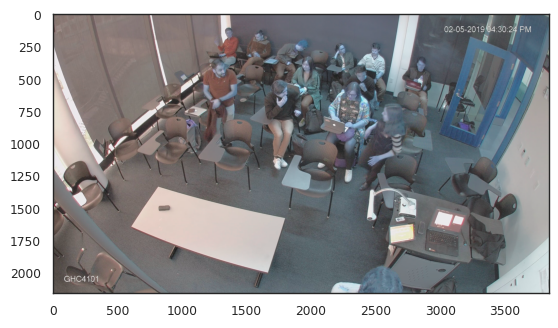

In [30]:
plt.imshow(video_frame)


In [ ]:
sessionA_id_map[4]


In [ ]:
frame_number, list(map(int, list(frame_data[0]['face'][0])))


In [34]:
# sprint({xr:emb_infoB[xr].shape for xr in emb_infoB})
from facenet_pytorch import InceptionResnetV1
facial_embedding_model = InceptionResnetV1(pretrained='vggface2',
                                           device='cpu').eval()


In [38]:
frame_result = frame_data[2]
body_bbox = frame_result['bbox']
faces = frame_result.get('face',np.array([]))
X_TL, Y_TL, X_BR, Y_BR = body_bbox[:4].astype(int)
X_TL, Y_TL, X_BR, Y_BR


(2336, 213, 2588, 759)

In [41]:
print(faces[0])
faces[0][0] += X_TL
faces[0][1] += Y_TL
faces[0][2] += X_TL
faces[0][3] += Y_TL


[4.8025874e+03 4.7446017e+02 4.8519961e+03 5.3527380e+02 9.9815565e-01
 1.3963817e+02 7.2336479e+01 1.6093015e+02 7.3059090e+01 1.4705969e+02
 8.8566505e+01 1.4152124e+02 9.5144897e+01 1.5875664e+02 9.5586380e+01]


In [43]:
faces = faces[0][:4].astype(int)


IndexError: invalid index to scalar variable.

In [44]:
faces


array([7138,  687, 7187,  748])

# Ground truth for id matching


In [188]:
gt_str = '''
3,12
3,36
11,17
30,17
5,10
5,35
9,9
1,0
6,8
4,8
14,1
16,6
21,4
7,2
7,35
0,5
-1,20
13,3
32,7
24,7
26,7
10,7
19,14
19,11
15,-1
2,-1
8,-1
-1,16
-1,26
-1,18
'''


In [189]:
gt_arr = gt_str.split("\n")[1:-1]
gt_arr = [xr.split(",") for xr in gt_arr]
df_gt = pd.DataFrame(gt_arr, columns=[sessionA,sessionB])
gt_map = df_gt.groupby(sessionA).agg({sessionB:lambda x: list(x)})[sessionB].to_dict()
gt_map


{'-1': ['20', '16', '26', '18'],
 '0': ['5'],
 '1': ['0'],
 '10': ['7'],
 '11': ['17'],
 '13': ['3'],
 '14': ['1'],
 '15': ['-1'],
 '16': ['6'],
 '19': ['14', '11'],
 '2': ['-1'],
 '21': ['4'],
 '24': ['7'],
 '26': ['7'],
 '3': ['12', '36'],
 '30': ['17'],
 '32': ['7'],
 '4': ['8'],
 '5': ['10', '35'],
 '6': ['8'],
 '7': ['2', '35'],
 '8': ['-1'],
 '9': ['9']}

# Method 1: Direct match between ids post filtering and median


In [151]:
idA = 9
idB = 4


In [152]:
framesA = gaze_infoA[idA][(gaze_infoA[idA].yaw.abs()<10) & (gaze_infoA[idA].pitch.abs()<20) & (gaze_infoA[idA].roll.abs()<20)].index.values
framesB = gaze_infoB[idB][(gaze_infoB[idB].yaw.abs()<10) & (gaze_infoB[idB].pitch.abs()<20) & (gaze_infoB[idB].roll.abs()<20)].index.values
len(framesA), len(framesB)


(0, 3730)

In [146]:
framesA_emb = emb_infoA[idA].loc[framesA]
framesB_emb = emb_infoB[idB].loc[framesB]
framesA_emb.shape, framesB_emb.shape


((1631, 512), (1614, 512))

In [149]:
medianA_emb = np.median(emb_infoA[idA].loc[framesA],axis=0)
medianB_emb = np.median(emb_infoB[idB].loc[framesB],axis=0)
sprint(medianA_emb.shape, medianB_emb.shape)
sprint(cdist(medianA_emb.reshape(1,-1), medianB_emb.reshape(1,-1)))


medianA_emb.shape, medianB_emb.shape : (512,) (512,)
cdist(medianA_emb.reshape(1,-1), medianB_emb.reshape(1,-1)) : [[0.37655235]]


In [150]:
dist_mat = cdist(framesA_emb.values, framesB_emb.values)
dist_mat.shape, np.median(dist_mat)


((1631, 1614), 0.6344439830825144)

<Axes: ylabel='Count'>

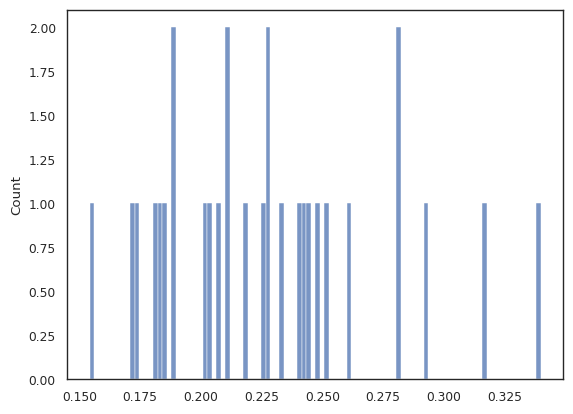

In [127]:
sns.histplot(np.mean(dist_mat,axis=1),bins=100)


<Axes: ylabel='Count'>

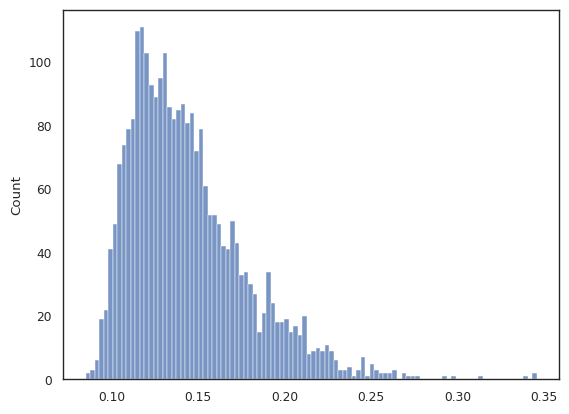

In [98]:
self_dist_matA = cdist(framesA_emb.values, framesA_emb.values,'cosine')
sns.histplot(np.mean(self_dist_matA,axis=1),bins=100)


<Axes: ylabel='Count'>

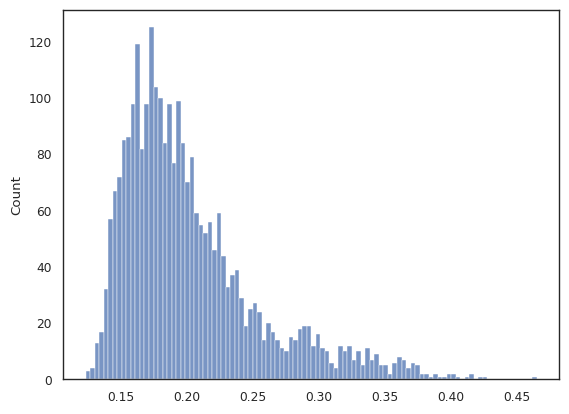

In [99]:
self_dist_matB = cdist(framesB_emb.values, framesB_emb.values,'cosine')
sns.histplot(np.mean(self_dist_matB,axis=1),bins=100)


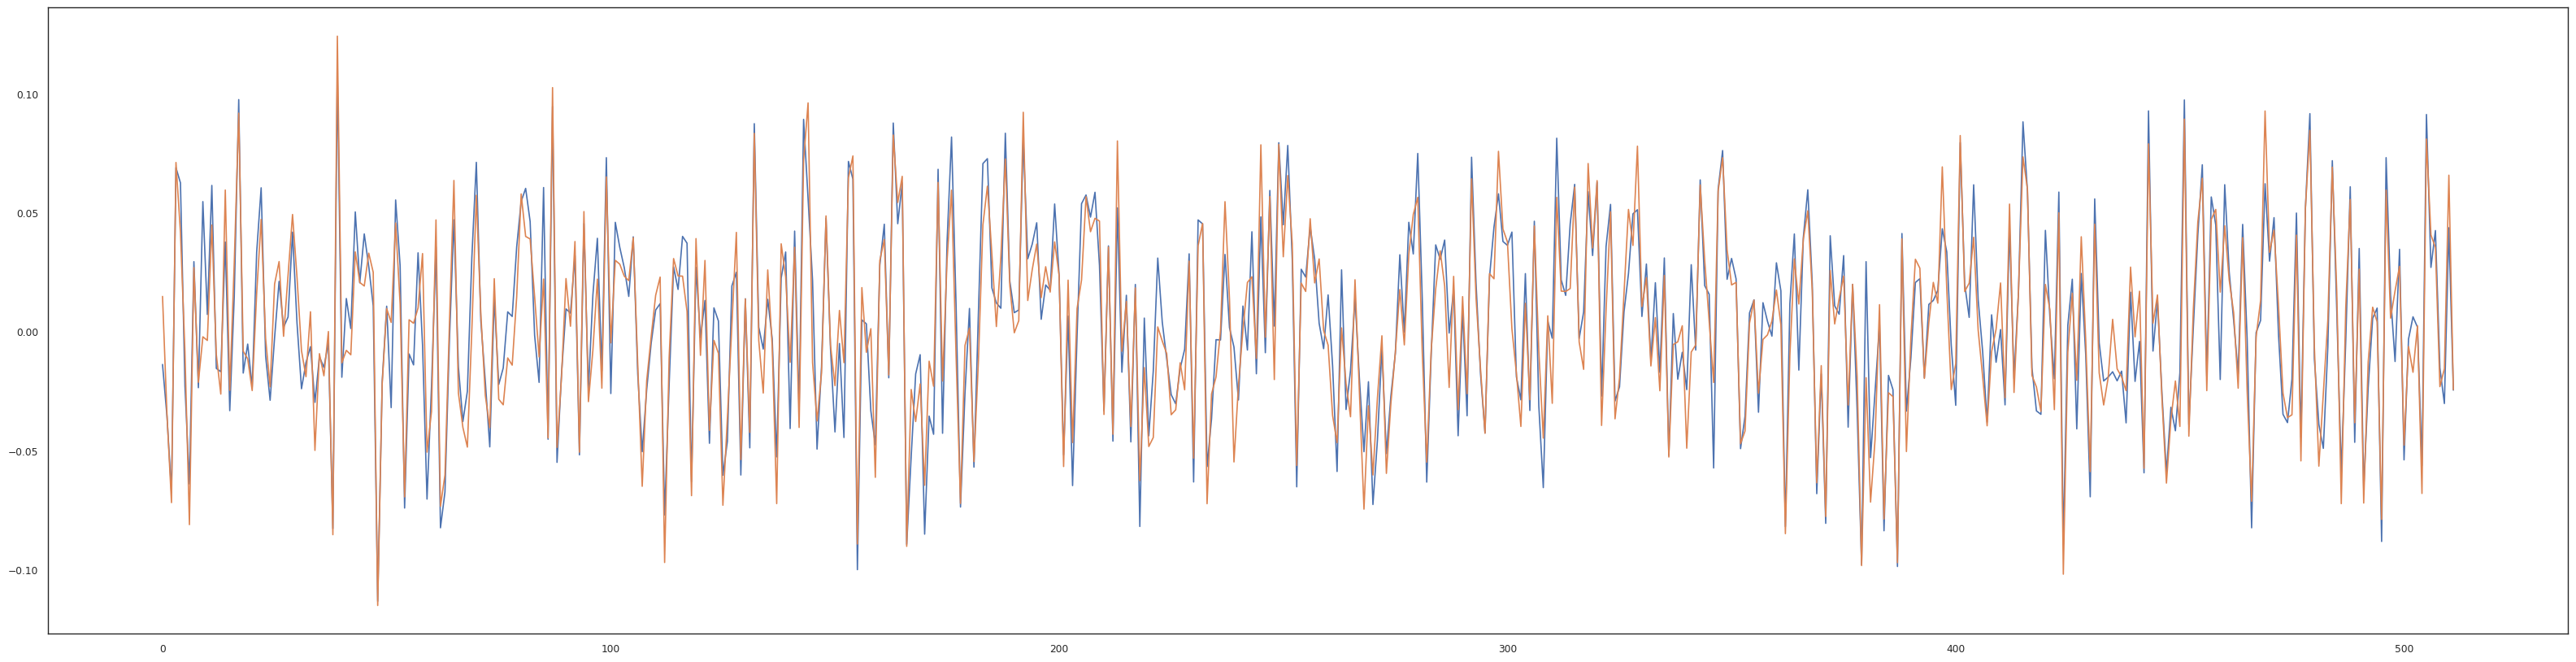

In [101]:
# plot median embedding for A and B
plt.figure(figsize=(40,10))
plt.plot(medianA_emb)
plt.plot(medianB_emb)


## First experiment (to be used for method 3)


In [ ]:
gaze_infoB.keys()


In [ ]:
gaze_infoA[0].head()


In [ ]:
emb_infoA[0].head()


In [ ]:
np.nanmax([gaze_infoA[xr].roll.max() for xr in gaze_infoA])


In [18]:
angle_bins = np.arange(-150,330,60)
angle_bins


array([-150,  -90,  -30,   30,   90,  150,  210,  270])

In [ ]:
for id in gaze_infoA:
    gaze_infoA[id]['roll_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].roll]
    gaze_infoA[id]['pitch_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].pitch]
    gaze_infoA[id]['yaw_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoA[id].yaw]

for id in gaze_infoB:
    gaze_infoB[id]['roll_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].roll]
    gaze_infoB[id]['pitch_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].pitch]
    gaze_infoB[id]['yaw_cat'] = [np.argmax(angle_bins>xr) for xr in gaze_infoB[id].yaw]
    

In [ ]:
# Data is ready, Now match id in one session to another session


In [ ]:
df_temp = gaze_infoA[1].reset_index().groupby(['roll_cat', 'pitch_cat', 'yaw_cat'],as_index=False).agg({'frame':[lambda x: list(x), 'count']})
df_temp.columns = ['roll_cat', 'pitch_cat', 'yaw_cat','list','count']
df_temp = df_temp.sort_values(by='count', ascending=False)
df_temp


In [ ]:
temp_gaze_framesA = df_temp.iloc[1]['list']
temp_roll, temp_pitch,temp_yaw= df_temp.iloc[1][['roll_cat','pitch_cat','yaw_cat']].values.tolist()
# temp_gaze_framesA
temp_roll, temp_pitch,temp_yaw


In [ ]:
tmp_emb = emb_infoA[1][emb_infoA[1].index.isin(temp_gaze_framesA)]
tmp_emb


In [ ]:
from sklearn.metrics import pairwise_distances


In [ ]:
dist_mat = pairwise_distances(tmp_emb.values[:,:])
# sns.heatmap(dist_mat)


In [ ]:
dist_thr = np.median(np.median(dist_mat, axis=1))
allowed_idx = np.median(dist_mat, axis=1)<dist_thr
dist_thr


In [ ]:
dist_mat = dist_mat[allowed_idx, :]
dist_mat = dist_mat[:,allowed_idx]
dist_mat.shape


In [ ]:
np.median(dist_mat, axis=1)<dist_thr
dist_mat.shape


In [ ]:
sns.heatmap(dist_mat)


In [ ]:
gaze_infoA.keys()


In [ ]:
tmp_emb.values


In [ ]:
dist_mat.shape


In [ ]:
# get embedding matrix for all gaze categories
@timer
def get_emb_matrices(df_id_gaze, df_id_emb, max_dist_threshold=0.5):
    df_gaze_cats = df_id_gaze.reset_index().groupby(['roll_cat', 'pitch_cat', 'yaw_cat'],as_index=False).agg({'frame':[lambda x: list(x), 'count']})
    df_gaze_cats.columns = ['roll_cat', 'pitch_cat', 'yaw_cat','list','count']
    df_gaze_cats = df_gaze_cats.sort_values(by='count', ascending=False)
    emb_matrices = {}
    for row_idx, row in df_gaze_cats.iterrows():
        temp_gaze_framesA = row['list']
        temp_roll, temp_pitch,temp_yaw= row['roll_cat'], row['pitch_cat'], row['yaw_cat']
    
        # get embedding matrix
        tmp_emb = df_id_emb[df_id_emb.index.isin(temp_gaze_framesA)]
    
        #filter outlier embeddings
        dist_mat = pairwise_distances(tmp_emb.values[:,:])
        dist_thr = min(np.median(np.median(dist_mat, axis=1)), max_dist_threshold)
        allowed_idx = np.median(dist_mat, axis=1)<dist_thr
    
        emb_matrix = tmp_emb.iloc[allowed_idx,:]
        emb_matrices[(temp_roll, temp_pitch,temp_yaw)] = emb_matrix
    return emb_matrices
    

emb_matsA = {}
for id in gaze_infoA.keys():
    sprint(id)
    emb_matsA[id] = get_emb_matrices(gaze_infoA[id],emb_infoA[id])
    # break


In [ ]:

emb_matsB = {}
for id in gaze_infoB.keys():
    sprint(id)
    emb_matsB[id] = get_emb_matrices(gaze_infoB[id],emb_infoB[id])


In [ ]:
# matching score between different ids
temp_s1_mats=emb_matsA[0]
temp_s2_mats=emb_matsB[0]


In [ ]:
common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
common_keys


In [ ]:
s1_emb_mat_key = temp_s1_mats[common_keys[0]]
s2_emb_mat_key = temp_s2_mats[common_keys[0]]
s1_emb_mat_key.shape, s2_emb_mat_key.shape


In [ ]:
from scipy.spatial.distance import cdist
# dist_res = cdist(s1_emb_mat_key, s2_emb_mat_key)


In [ ]:
dist_res.shape


In [ ]:
# sns.heatmap(dist_res)


In [ ]:
match_score = np.median(dist_res)


In [ ]:
emb_matsA.keys()


In [ ]:
# get match scores between one single id from sessionA, and across all ids from sessionB
temp_idA_scores = dict()
temp_s1_mats=emb_matsA[697]
for idB in emb_matsB:
    temp_s2_mats = emb_matsB[idB]
    common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
    temp_idA_scores[idB]={}
    for gaze_key in common_keys:
        s1_emb_mat_key = temp_s1_mats[gaze_key]
        s2_emb_mat_key = temp_s2_mats[gaze_key]
        dist_res = cdist(s1_emb_mat_key, s2_emb_mat_key)
        temp_idA_scores[idB][gaze_key] = np.median(dist_res)        
    


In [ ]:
df_idA = pd.DataFrame(temp_idA_scores)


In [ ]:
df_idA.min().sort_values()


In [ ]:
df_idA.min().sort_values()


In [ ]:
# get final id-match matrix between both sessions


In [ ]:
id_match_matrix = {}
for idA in emb_matsA:
    temp_s1_mats=emb_matsA[idA]
    id_match_matrix[idA]={}
    for idB in emb_matsB:
        temp_s2_mats = emb_matsB[idB]
        common_keys = [xr for xr in temp_s1_mats.keys() if xr in temp_s2_mats.keys()]
        # temp_idA_scores[idB]={}
        gaze_cat_scores= []
        for gaze_key in common_keys:
            s1_emb_mat_key = temp_s1_mats[gaze_key]
            s2_emb_mat_key = temp_s2_mats[gaze_key]
            dist_res = np.median(cdist(s1_emb_mat_key, s2_emb_mat_key))
            if dist_res >= 0:
                gaze_cat_scores.append(dist_res)
            # temp_idA_scores[idB][gaze_key] = np.median(dist_res) 
        if len(gaze_cat_scores)>0:
            id_match_matrix[idA][idB] = np.nanmin(gaze_cat_scores)


In [ ]:
df_id_match = pd.DataFrame(id_match_matrix)


In [ ]:
plt.figure(figsize=(30,10))
sns.heatmap(df_id_match.round(2), annot=True, cmap='bone_r')


In [ ]:
df_id_match


# Clean Implementation 1: Using k% gaze filtering and median embeddings for matching


In [190]:
MAX_GAZE_DEVIATION_DEG = 30
# MAX_EMBEDDING_FRAMES = 1000
MIN_EMBEDDING_FRAMES = 100


In [191]:
match_scores = {}
match_info = {}
np.random.seed(42)
for idA,idB in product(emb_infoA.keys(), emb_infoB.keys()):
    #filter correct frames
    framesA = gaze_infoA[idA][
        (gaze_infoA[idA].yaw.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].pitch.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values
    framesB = gaze_infoB[idB][
        (gaze_infoB[idB].yaw.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].pitch.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values

    num_framesA, num_framesB = len(framesA), len(framesB)
    if (num_framesA<MIN_EMBEDDING_FRAMES) | (num_framesB <MIN_EMBEDDING_FRAMES):
        sprint(f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}")
        continue
    
    # select_framesA  =  np.random.choice(framesA, MAX_EMBEDDING_FRAMES) if (num_framesA > MAX_EMBEDDING_FRAMES) else  framesA
    # select_framesB  =  np.random.choice(framesB, MAX_EMBEDDING_FRAMES) if (num_framesB > MAX_EMBEDDING_FRAMES) else  framesB

    #get id embeddings
    
    medianA_emb = np.median(emb_infoA[idA].loc[framesA],axis=0)
    medianB_emb = np.median(emb_infoB[idB].loc[framesB],axis=0)
    match_distance = cdist(medianA_emb.reshape(1,-1), medianB_emb.reshape(1,-1))[0][0]
    if idA not in match_scores:
        match_scores[idA] = {}
        match_info[idA] = {}
    match_scores[idA][idB] = match_distance
    match_info[idA][idB] = dict(match_score=match_distance, framesA=framesA, framesB=framesB)
    sprint(idA, idB, match_distance)
    
    
    
    

idA, idB, match_distance : 0 0 0.40031744967056493
idA, idB, match_distance : 0 1 0.3729883140269234
idA, idB, match_distance : 0 2 0.2819798935261926
idA, idB, match_distance : 0 3 0.3253756619647638
idA, idB, match_distance : 0 4 0.20961929766178247
idA, idB, match_distance : 0 5 0.48064969245771294
idA, idB, match_distance : 0 6 0.31394921760063216
idA, idB, match_distance : 0 7 0.35118857005003173
idA, idB, match_distance : 0 8 0.3269205473149535
idA, idB, match_distance : 0 9 0.4200936145324954
idA, idB, match_distance : 0 10 0.5030895196904056
idA, idB, match_distance : 0 11 0.35478866281770066
idA, idB, match_distance : 0 12 0.3947247232932404
f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}" : Not sufficient frames to match 0:7784,13:14
idA, idB, match_distance : 0 14 0.3030825217145072
f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}" : Not sufficient frames to match 0:7784,15:2
idA, idB, match_distance : 0 16 0.4992878512817

In [192]:
df_matching_methodA = pd.DataFrame(match_scores)
df_matching_methodA.shape


(26, 23)

In [193]:
df_matching_methodA


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,24,26,30,31,32
0,0.400317,0.160398,0.467463,0.343354,0.545554,0.564473,0.442918,0.783907,0.287886,0.248193,0.360972,0.310133,0.588749,0.426275,0.470358,0.576870,0.426867,0.507206,0.356754,0.347518,0.311031,0.299797,0.327863
1,0.372988,0.319910,0.450638,0.373569,0.328838,0.324697,0.299388,0.568561,0.346557,0.394671,0.214885,0.510029,0.410240,0.376545,0.180944,0.358270,0.232551,0.385222,0.223688,0.245347,0.483188,0.310452,0.249391
2,0.281980,0.552531,0.353664,0.594702,0.333420,0.637804,0.660789,0.290655,0.532777,0.472598,0.411765,0.527057,0.260528,0.311489,0.421416,0.732933,0.538523,0.336619,0.404337,0.474988,0.515433,0.546766,0.499356
3,0.325376,0.556177,0.338818,0.654852,0.287973,0.665413,0.696367,0.308639,0.562081,0.516815,0.429146,0.596190,0.270550,0.286241,0.410453,0.746857,0.535091,0.392074,0.435024,0.519766,0.591865,0.587971,0.531141
4,0.209619,0.355958,0.209496,0.532450,0.262397,0.557447,0.520299,0.508391,0.374702,0.356560,0.226272,0.447034,0.272033,0.280836,0.299246,0.596097,0.319652,0.235398,0.206288,0.261281,0.429030,0.387234,0.275947
5,0.480650,0.687059,0.498502,0.731276,0.332170,0.698447,0.755116,0.159172,0.690462,0.638662,0.512359,0.715066,0.273487,0.461076,0.477320,0.767549,0.616320,0.455902,0.528694,0.609063,0.705336,0.698984,0.623291
6,0.313949,0.363395,0.324990,0.527418,0.282226,0.474887,0.441360,0.540228,0.388189,0.453559,0.275781,0.550686,0.350237,0.349579,0.244085,0.481239,0.218470,0.335242,0.266892,0.337916,0.526930,0.396804,0.332221
7,0.351189,0.136211,0.416188,0.294854,0.431075,0.412881,0.281696,0.690286,0.228897,0.258719,0.217291,0.390436,0.487773,0.382241,0.304343,0.436915,0.240267,0.398099,0.206678,0.189833,0.370192,0.178929,0.164531
8,0.326921,0.253229,0.429889,0.285658,0.465397,0.389303,0.281341,0.657950,0.279553,0.315431,0.312177,0.406919,0.507186,0.366816,0.326982,0.447100,0.300174,0.416873,0.293285,0.296573,0.378433,0.217988,0.292773
9,0.420094,0.314360,0.474528,0.352975,0.583452,0.623804,0.482944,0.782470,0.311590,0.192321,0.388421,0.244141,0.583601,0.477812,0.537115,0.676657,0.490868,0.464265,0.366772,0.322906,0.245877,0.279651,0.319316


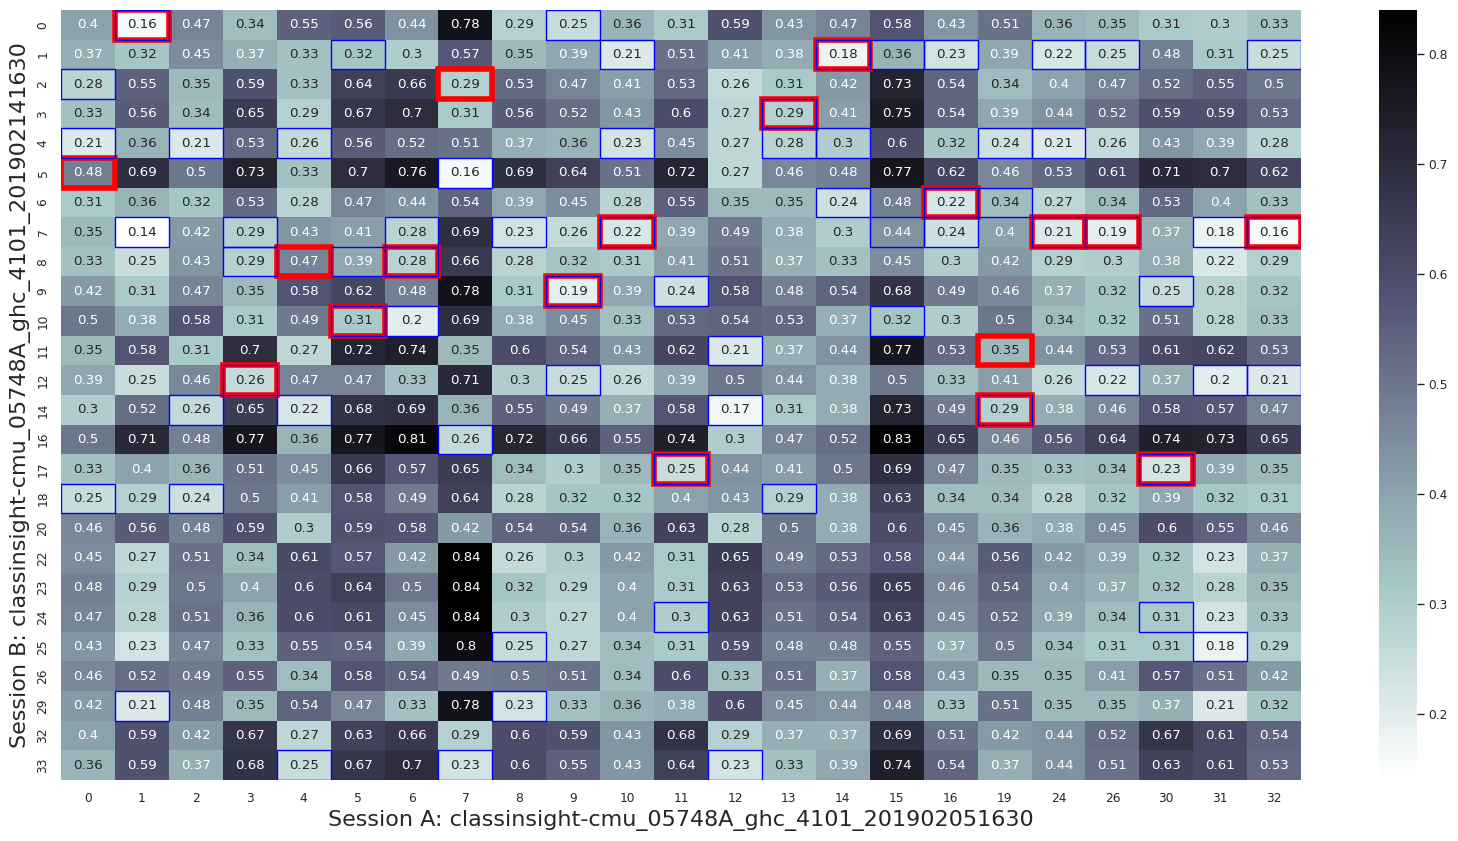

In [194]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching_methodA.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching_methodA.columns) and (gtB in df_matching_methodA.index):
                locA, locB = df_matching_methodA.columns.get_loc(gtA), df_matching_methodA.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching_methodA.shape[1]):
    locBs = df_matching_methodA.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method1_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')


# Method 2:Get distance between all pairs and get median distance across all pairs.


In [195]:
MAX_GAZE_DEVIATION_DEG = 30 # for basic filtering of very random gaze
MAX_EMBEDDING_FRAMES = 1000
MIN_EMBEDDING_FRAMES = 100


In [196]:
match_scores = {}
matching_info_dictB = {}
np.random.seed(42)
for idA,idB in product(emb_infoA.keys(), emb_infoB.keys()):
    #filter correct frames
    framesA = gaze_infoA[idA][
        (gaze_infoA[idA].yaw.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].pitch.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values
    framesB = gaze_infoB[idB][
        (gaze_infoB[idB].yaw.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].pitch.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values

    num_framesA, num_framesB = len(framesA), len(framesB)
    if (num_framesA<MIN_EMBEDDING_FRAMES) | (num_framesB <MIN_EMBEDDING_FRAMES):
        sprint(f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}")
        continue
    
    select_framesA  =  np.random.choice(framesA, MAX_EMBEDDING_FRAMES) if (num_framesA > MAX_EMBEDDING_FRAMES) else  framesA
    select_framesB  =  np.random.choice(framesB, MAX_EMBEDDING_FRAMES) if (num_framesB > MAX_EMBEDDING_FRAMES) else  framesB

    #get id embeddings
    
    match_distance_matrix = cdist(emb_infoA[idA].loc[select_framesA], emb_infoB[idB].loc[select_framesB])
    sprint(match_distance_matrix.shape)
    match_distance = np.mean(np.median(match_distance_matrix,axis=1))
    if idA not in match_scores:
        match_scores[idA] = {}
        matching_info_dictB[idA] = {}
    match_scores[idA][idB] = match_distance
    matching_info_dictB[idA][idB] = dict(match_score=match_distance, match_matrix= match_distance_matrix,framesA=select_framesA, framesB=select_framesB)
    sprint(idA, idB, match_distance)
    

df_matching_methodB = pd.DataFrame(match_scores)
    

match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 0 0.6207200014022407
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 1 0.6340862589775176
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 2 0.564286287428047
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 3 0.5786991709608676
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 4 0.5411011223053298
match_distance_matrix.shape : (1000, 691)
idA, idB, match_distance : 0 5 0.6612266650780786
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 6 0.6163588855806813
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 7 0.6280209413688749
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 8 0.6430773079841161
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 9 0.654142535894131
match_distance_matrix.shape : (1000, 1000)
idA, idB, match_distance : 0 1

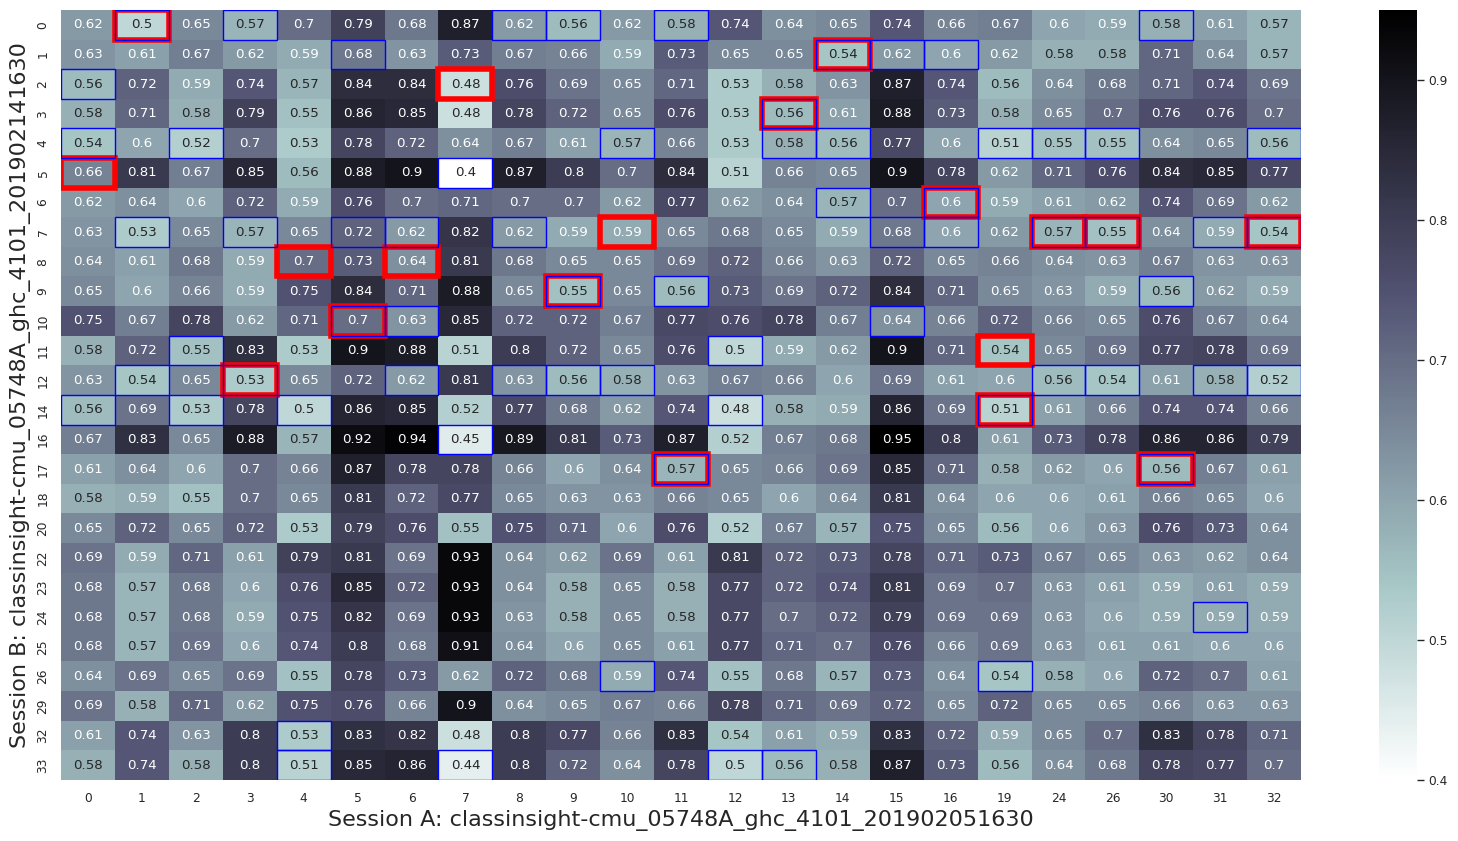

In [197]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching_methodB.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching_methodB.columns) and (gtB in df_matching_methodB.index):
                locA, locB = df_matching_methodB.columns.get_loc(gtA), df_matching_methodB.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching_methodB.shape[1]):
    locBs = df_matching_methodB.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')


## Method 2b: Use median of medians


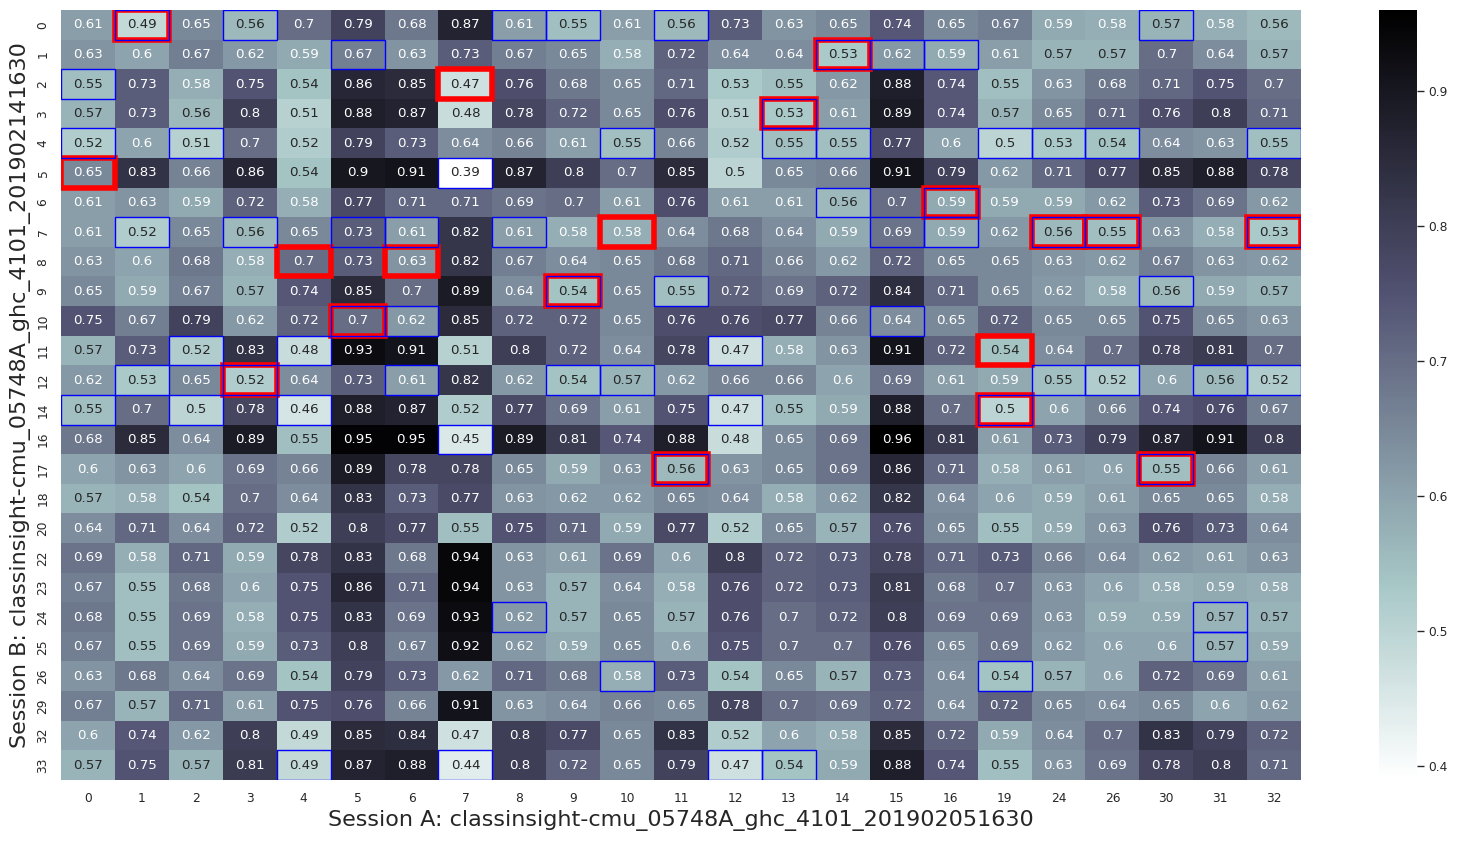

In [198]:
match_scores = {}
for idA in matching_info_dictB:
    match_scores[idA] = {}
    for idB in matching_info_dictB[idA]:
        match_matrix = matching_info_dictB[idA][idB]['match_matrix']
        match_distance = np.median(np.median(match_matrix,axis=1))
        match_scores[idA][idB] = match_distance

df_matching = pd.DataFrame(match_scores)

#--------
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching.columns) and (gtB in df_matching.index):
                locA, locB = df_matching.columns.get_loc(gtA), df_matching.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching.shape[1]):
    locBs = df_matching.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2b_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')


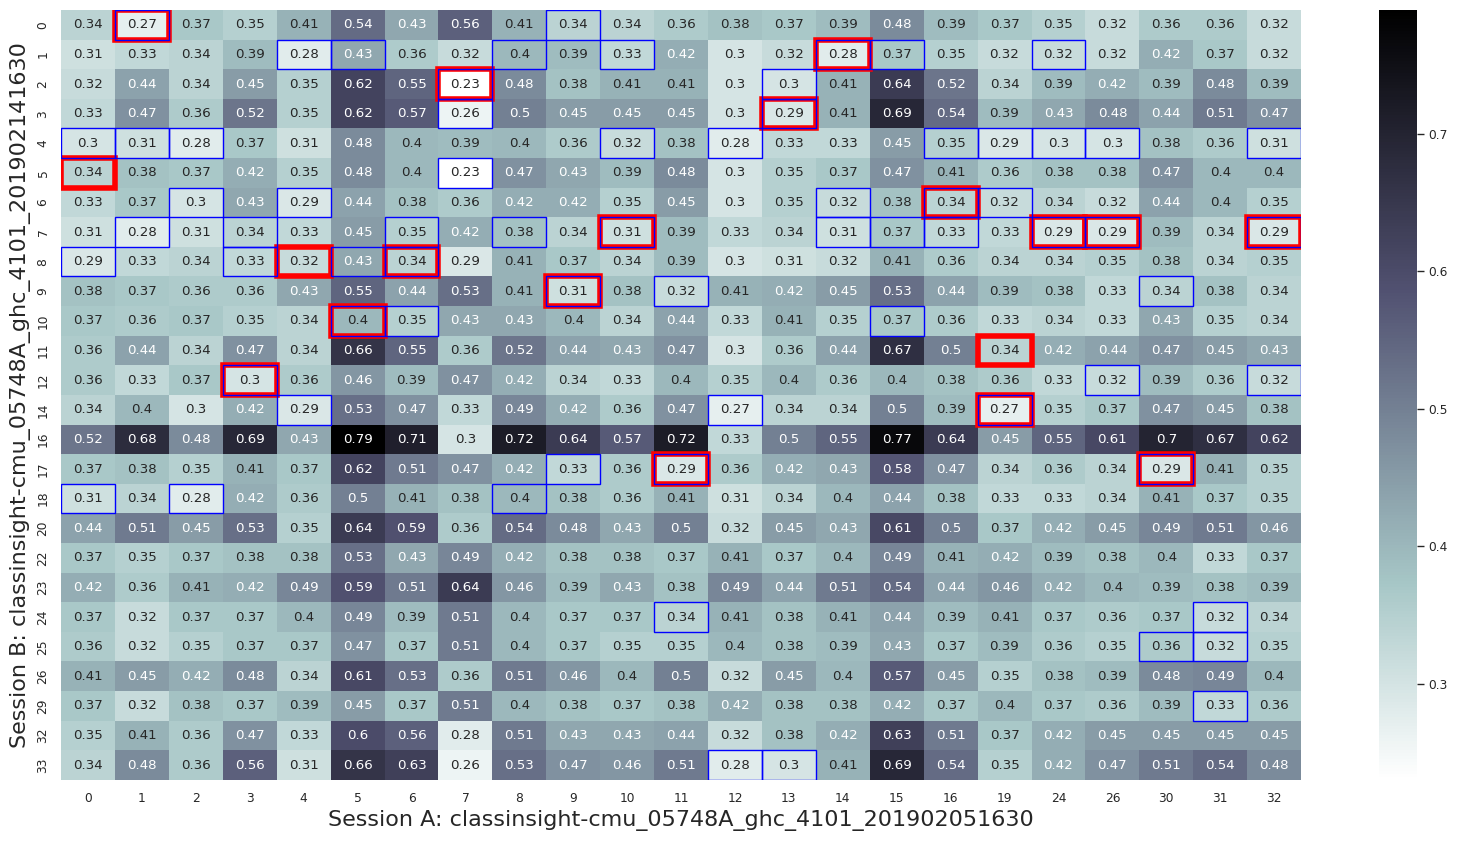

In [199]:
match_scores = {}
for idA in matching_info_dictB:
    match_scores[idA] = {}
    for idB in matching_info_dictB[idA]:
        match_matrix = matching_info_dictB[idA][idB]['match_matrix']
        match_distance = np.median(np.min(match_matrix,axis=1))
        match_scores[idA][idB] = match_distance

df_matching = pd.DataFrame(match_scores)

#--------
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching.columns) and (gtB in df_matching.index):
                locA, locB = df_matching.columns.get_loc(gtA), df_matching.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching.shape[1]):
    locBs = df_matching.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2c_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')


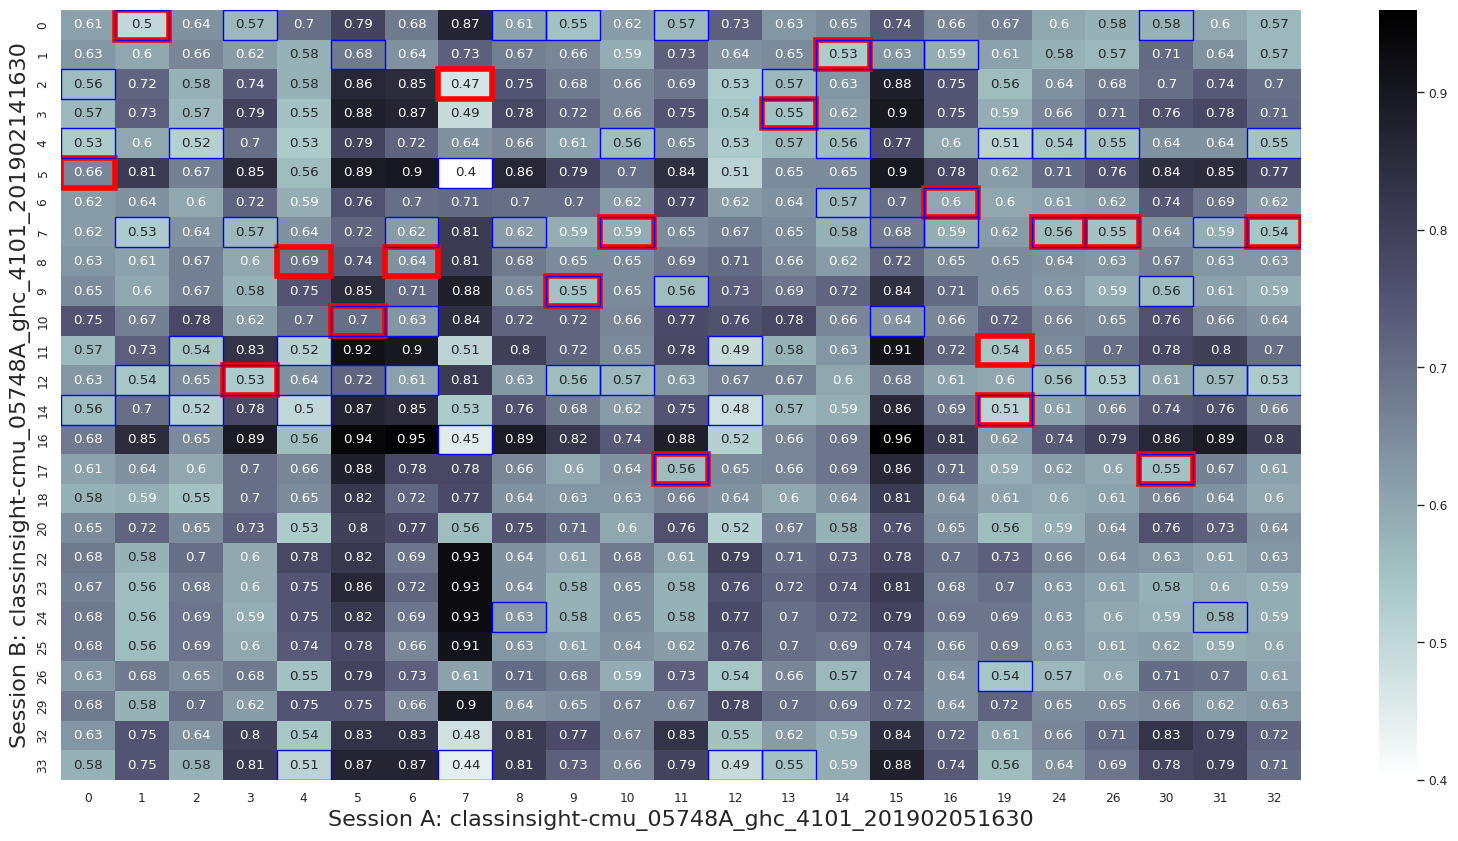

In [200]:
from sklearn.preprocessing import normalize
match_scores = {}
for idA in matching_info_dictB:
    match_scores[idA] = {}
    for idB in matching_info_dictB[idA]:
        match_matrix = deepcopy(matching_info_dictB[idA][idB]['match_matrix'])
        # match_matrix = normalize(match_matrix, axis=1, norm='l1')
        match_distance = np.median(match_matrix.flatten())
        match_scores[idA][idB] = match_distance

df_matching = pd.DataFrame(match_scores)

#--------
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching.columns) and (gtB in df_matching.index):
                locA, locB = df_matching.columns.get_loc(gtA), df_matching.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching.shape[1]):
    locBs = df_matching.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2d_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')


# Method 3: Use spectral clustering to get clean set of embeddings, calculate their centroid, and then evaluate distance


In [201]:
from sklearn.cluster import DBSCAN
EPS = 0.4
MIN_PTS = 100


In [202]:

np.random.seed(42)
clustered_median_embA = {}
for idA in emb_infoA:
    emb_cluA = DBSCAN(min_samples=MIN_PTS, eps=EPS)
    emb_cluA.fit(emb_infoA[idA].values)
    if max(emb_cluA.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {idA}")
        continue
    best_cluster_id = pd.Series(emb_cluA.labels_[emb_cluA.labels_>=0]).value_counts().index[0]
    framesA = emb_infoA[idA].iloc[emb_cluA.labels_==best_cluster_id].index.values
    clustered_median_embA[idA] = np.median(emb_infoA[idA].loc[framesA],axis=0)
    
clustered_median_embB = {}
for idB in emb_infoB:
    emb_cluB = DBSCAN(min_samples=MIN_PTS, eps=EPS)
    emb_cluB.fit(emb_infoB[idB].values)
    if max(emb_cluB.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {idB}")
        continue
    best_cluster_id = pd.Series(emb_cluB.labels_[emb_cluB.labels_>=0]).value_counts().index[0]
    framesB = emb_infoB[idB].iloc[emb_cluB.labels_==best_cluster_id].index.values
    clustered_median_embB[idB] = np.median(emb_infoB[idB].loc[framesB],axis=0)
# #filter correct frames
# # select_framesA  =  np.random.choice(framesA, MAX_EMBEDDING_FRAMES) if (num_framesA > MAX_EMBEDDING_FRAMES) else  framesA
# # select_framesB  =  np.random.choice(framesB, MAX_EMBEDDING_FRAMES) if (num_framesB > MAX_EMBEDDING_FRAMES) else  framesB

# #get id embeddings
    
# medianA_emb = np.median(emb_infoA[idA].loc[framesA],axis=0)
# medianB_emb = np.median(emb_infoB[idB].loc[framesB],axis=0)
# match_distance = cdist(medianA_emb.reshape(1,-1), medianB_emb.reshape(1,-1))[0][0]
# if idA not in match_scores:
#     match_scores[idA] = {}
#     match_info3[idA] = {}
# match_scores[idA][idB] = match_distance
# match_info3[idA][idB] = dict(match_score=match_distance, framesA=framesA, framesB=framesB)
# sprint(idA, idB, match_distance)

    
    
    

f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 17
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 18
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 20
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 22
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 23
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 25
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 27
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 28
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 29
f"All fram

In [203]:
match_scores = {}
match_info3 = {}
for idA in clustered_median_embA:
    match_scores[idA] = {}
    for idB in clustered_median_embB:
        match_scores[idA][idB] = cdist(clustered_median_embA[idA].reshape(1,-1), clustered_median_embB[idB].reshape(1,-1))[0][0]
        
df_matching_methodC = pd.DataFrame(match_scores)
df_matching_methodC.shape    


(29, 23)

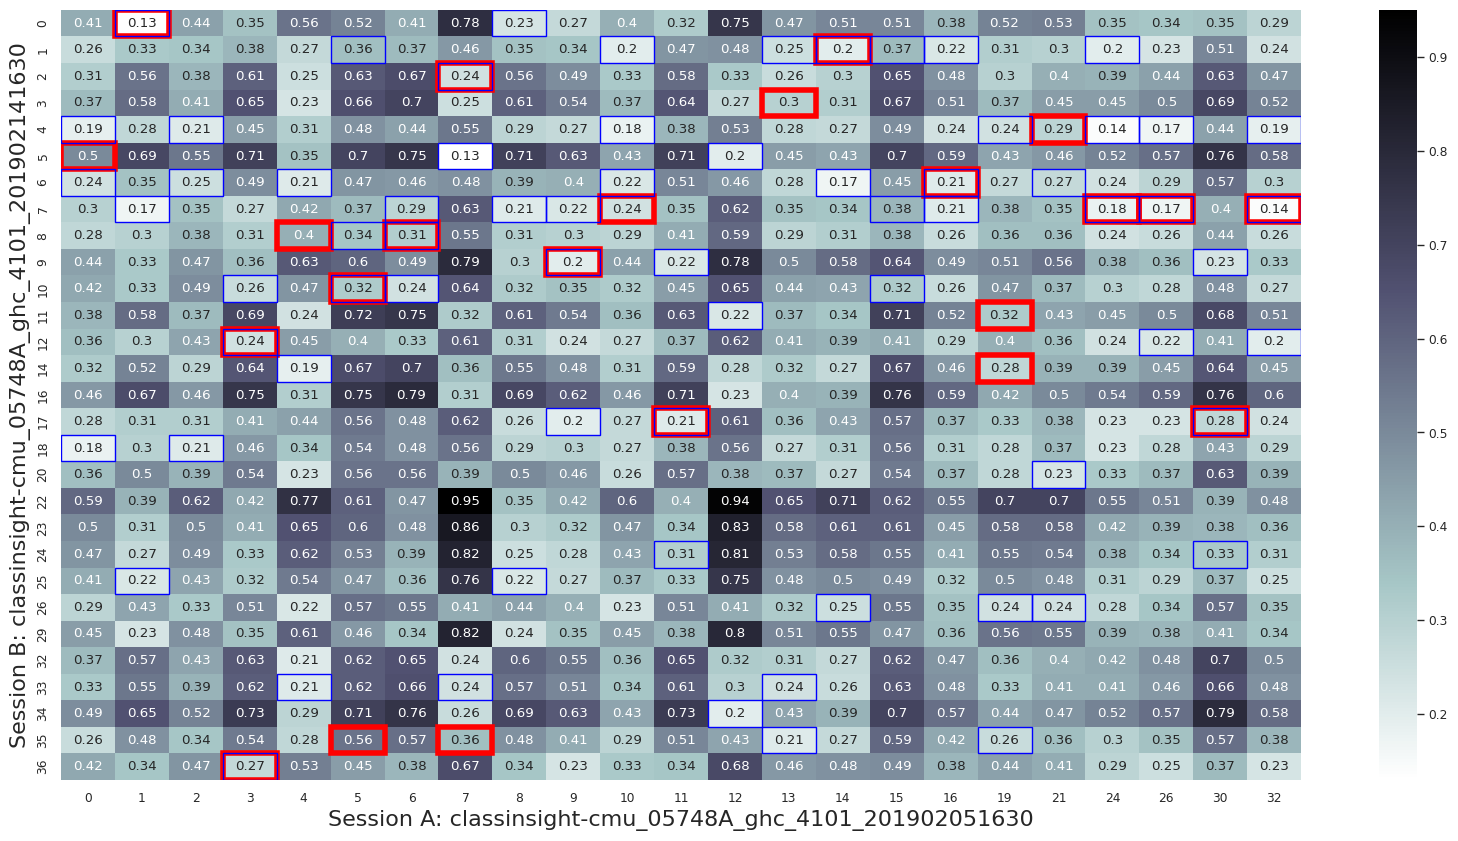

In [204]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching_methodC.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching_methodC.columns) and (gtB in df_matching_methodC.index):
                locA, locB = df_matching_methodC.columns.get_loc(gtA), df_matching_methodC.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching_methodC.shape[1]):
    locBs = df_matching_methodC.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method3_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')
